In [1]:
from cellpose import io,models # https://www.nature.com/articles/s41592-020-01018-x
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
model = models.Cellpose(model_type='cyto') 
image = io.imread('img.jpg')

In [3]:
import numpy as np
image = np.array(image)
print("Image shape:", image.shape)

Image shape: (936, 936, 3)


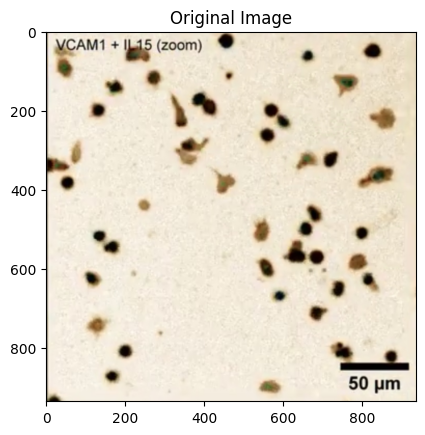

In [13]:
plt.imshow(image)
plt.title("Original Image")
plt.show()

In [5]:
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
gray_image = np.array(gray_image)
print("Image shape:", gray_image.shape)

Image shape: (936, 936)


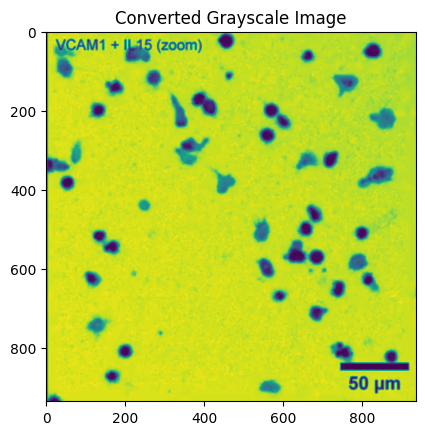

In [14]:
plt.imshow(gray_image)
plt.title("Converted Grayscale Image")
plt.show()

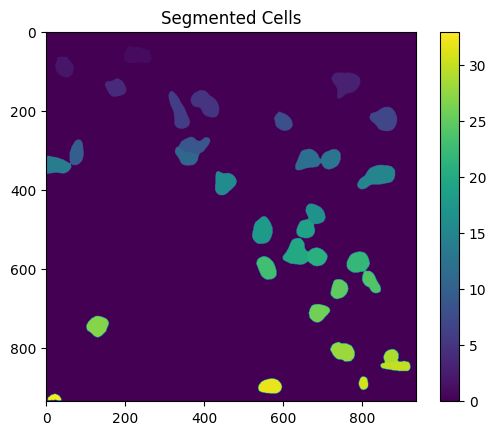

In [15]:
masks, flows, styles, diams = model.eval(image, diameter=50, channels=[0, 0])  # here we have chosen avg diameter of cells as 50

if masks is not None and masks.max() > 0:
    plt.imshow(masks) 
    plt.title("Segmented Cells")
    plt.colorbar()
    plt.show()
else:
    print("No cells were segmented. Try adjusting parameters or verify input.")
# will have to train our dataset on this cellpose model to make it perform instance segmentation accurately. 
# in our current result we are just using the pre trained model without any supervised learnings, that's why it has missed a few cells!!

In [9]:
from scipy.ndimage import center_of_mass

unique_ids = np.unique(masks)
unique_ids = unique_ids[unique_ids > 0]

# Calculating centroids
centroids = [center_of_mass(masks == i) for i in unique_ids]

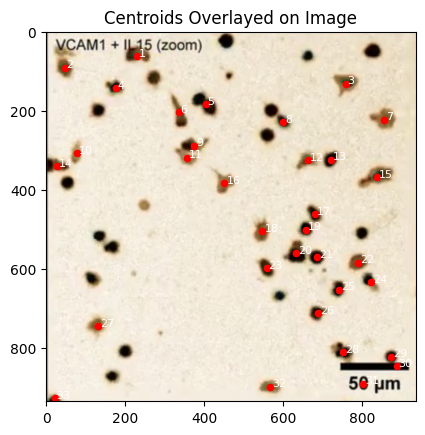

In [10]:
plt.imshow(image, cmap='gray') 
plt.title("Centroids Overlayed on Image")

for id_, centroid in zip(unique_ids, centroids):
    plt.scatter(centroid[1], centroid[0], color='red', s=20, label=f"ID {id_}" if id_ == unique_ids[0] else "")  # Plot each centroid
    plt.text(centroid[1] + 5, centroid[0], str(id_), color='white', fontsize=8)  # Label IDs near centroids

plt.show()

In [11]:
# Computing Nearest Neighbor Distance for Each Cell
from scipy.ndimage import center_of_mass
from scipy.spatial import distance


# Calculate the nearest neighbor distance for each centroid
nearest_neighbor_distances = []
for i, centroid in enumerate(centroids):
    # Calculate distances to all other centroids
    distances = [distance.euclidean(centroid, other_centroid) for j, other_centroid in enumerate(centroids) if i != j]
    # Find the nearest neighbor distance
    nearest_neighbor_distances.append(min(distances))

for i, (centroid, nn_distance) in enumerate(zip(centroids, nearest_neighbor_distances), start=1):
    print(f"Cell ID: {unique_ids[i-1]}, Centroid: {centroid}, Nearest Neighbor Distance: {nn_distance}")

Cell ID: 1, Centroid: (np.float64(61.25445503522586), np.float64(230.44799005387483)), Nearest Neighbor Distance: 98.00964009953324
Cell ID: 2, Centroid: (np.float64(90.70607028753993), np.float64(46.1171458998935)), Nearest Neighbor Distance: 140.3510573175262
Cell ID: 3, Centroid: (np.float64(131.5891875381796), np.float64(757.8020769700672)), Nearest Neighbor Distance: 133.80086798301488
Cell ID: 4, Centroid: (np.float64(142.9916805324459), np.float64(176.3655019412091)), Nearest Neighbor Distance: 98.00964009953324
Cell ID: 5, Centroid: (np.float64(183.1635908664373), np.float64(403.4745073506412)), Nearest Neighbor Distance: 71.05819701458734
Cell ID: 6, Centroid: (np.float64(203.795232936078), np.float64(335.47742867461176)), Nearest Neighbor Distance: 71.05819701458734
Cell ID: 7, Centroid: (np.float64(222.10114566284778), np.float64(856.3427168576105)), Nearest Neighbor Distance: 133.80086798301488
Cell ID: 8, Centroid: (np.float64(229.01065162907267), np.float64(599.6541353383

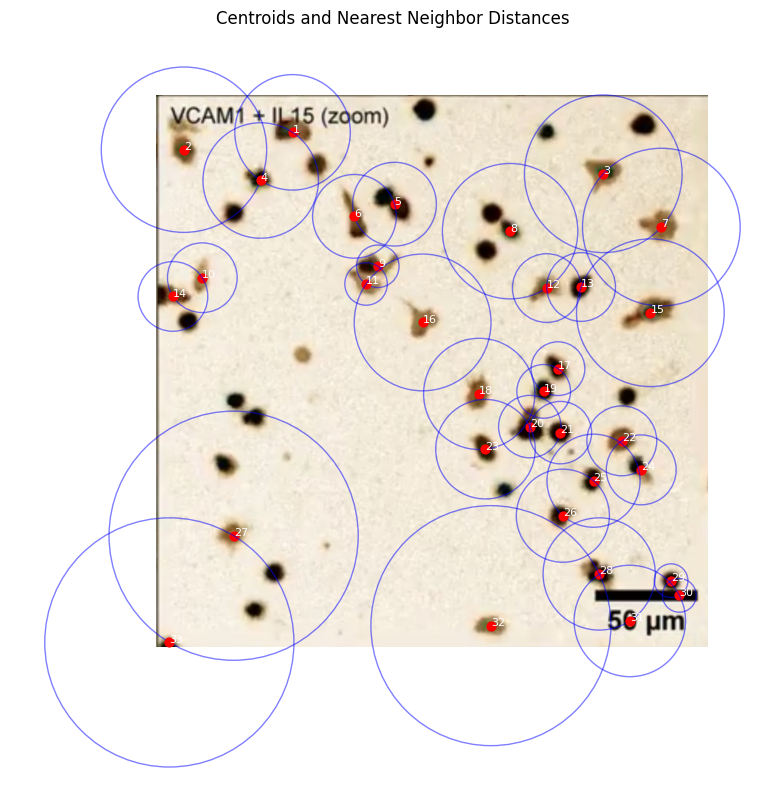

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.title("Centroids and Nearest Neighbor Distances")

# Plot each centroid
for i, (centroid, dist) in enumerate(zip(centroids, nearest_neighbor_distances), 1):
    y, x = centroid  # Note: centroids are in (row, col) format
    plt.scatter(x, y, color='red', s=40, label='Centroid' if i == 1 else "")
    plt.text(x, y, f"{i}", color='white', fontsize=8)  # Label cell IDs
    circle = plt.Circle((x, y), dist, color='blue', fill=False, linewidth=1, alpha=0.5)
    plt.gca().add_patch(circle)

plt.axis("off")
plt.show()

The nearest neighbor distance measures the **Euclidean distance** between a given cell’s centroid and the centroid of its closest neighboring cell. This helps quantify how densely or sparsely the cells are distributed in the image.
- Cells with small nearest neighbor distances might be part of dense clusters.
- Cells with large nearest neighbor distances may be isolated.